# Exercise-4: Model Comparison

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc

# Load and preprocess dataset
df = pd.read_csv("../archive/data.csv")
df = df.drop(columns=['id', 'Unnamed: 32'], errors='ignore')

X = df.drop(columns=['diagnosis'])
y = df['diagnosis'].map({'M': 1, 'B': 0})

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

### Q4.1 Compare Decision Tree and SVM results from the training set (cross-validation mean +- std) and validation set. Plot the performance comparison plot (scatterplots, ROC curves). Which model generalizes better? 

Results from Decision Tree (default parameters):
- Validation Accuracy: 0.9386
- Mean Accuracy: 0.9386

Results from SVM:
- Validation Accuracy Mean: 0.9754
- Validation Accuracy Std: 0.0195

Cross-Validation Results (Training Set)
Decision Tree: Mean=0.9231, Std=0.0326
Linear SVM:    Mean=0.9648, Std=0.0108

Validation Set Results
Decision Tree Validation Accuracy: 0.9298
Linear SVM Validation Accuracy:    0.9649


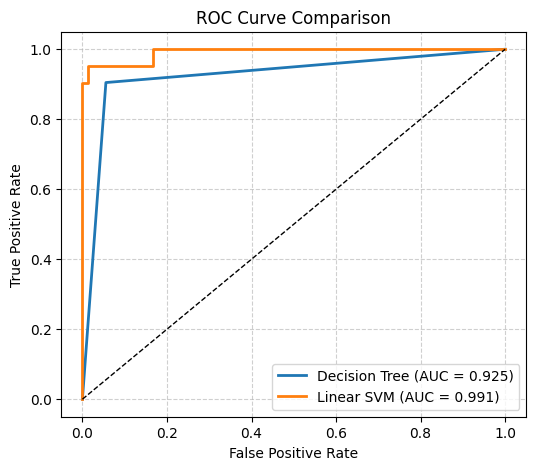

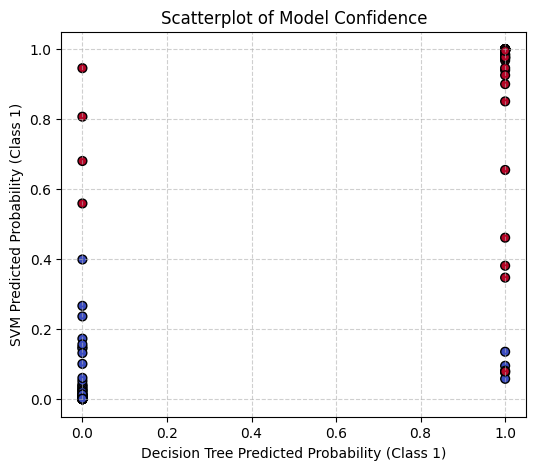

In [8]:

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_std, y, test_size=0.2, stratify=y, random_state=42)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Decision Tree
tree_clf = DecisionTreeClassifier(random_state=42)
tree_scores = cross_val_score(tree_clf, X_train, y_train, cv=kf)
tree_clf.fit(X_train, y_train)

# Linear SVM
svm_clf = SVC(kernel="linear", probability=True, random_state=42)
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=kf)
svm_clf.fit(X_train, y_train)

# Predictions on validation set
y_val_pred_tree = tree_clf.predict(X_val)
y_val_prob_tree = tree_clf.predict_proba(X_val)[:, 1]
y_val_pred_svm = svm_clf.predict(X_val)
y_val_prob_svm = svm_clf.predict_proba(X_val)[:, 1]

# Accuracy scores
acc_tree = accuracy_score(y_val, y_val_pred_tree)
acc_svm = accuracy_score(y_val, y_val_pred_svm)

print("Cross-Validation Results (Training Set)")
print(f"Decision Tree: Mean={tree_scores.mean():.4f}, Std={tree_scores.std():.4f}")
print(f"Linear SVM:    Mean={svm_scores.mean():.4f}, Std={svm_scores.std():.4f}\n")

print("Validation Set Results")
print(f"Decision Tree Validation Accuracy: {acc_tree:.4f}")
print(f"Linear SVM Validation Accuracy:    {acc_svm:.4f}")

# ROC curves
fpr_tree, tpr_tree, _ = roc_curve(y_val, y_val_prob_tree)
roc_auc_tree = auc(fpr_tree, tpr_tree)
fpr_svm, tpr_svm, _ = roc_curve(y_val, y_val_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(6, 5))
plt.plot(fpr_tree, tpr_tree, label=f"Decision Tree (AUC = {roc_auc_tree:.3f})", lw=2)
plt.plot(fpr_svm, tpr_svm, label=f"Linear SVM (AUC = {roc_auc_svm:.3f})", lw=2)
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Scatterplot of predicted probabilities
plt.figure(figsize=(6, 5))
plt.scatter(y_val_prob_tree, y_val_prob_svm, c=y_val, cmap="coolwarm", edgecolor='k', s=40)
plt.xlabel("Decision Tree Predicted Probability (Class 1)")
plt.ylabel("SVM Predicted Probability (Class 1)")
plt.title("Scatterplot of Model Confidence")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

### Q4.2 Discuss the trade-off between usability and accuracy

Due to the critical importance a false negative could produce (a patient could risk going home without knowing the true nature of their diagnosis), we have to harshly punish false negatives.

The way $F_\beta$ scores work is that the higher the $\beta$, the more weight is put on recall. The $F_\beta$ score is defined as:
The $F_\beta$ score is defined as:

$$
F_\beta = (1 + \beta^2) \frac{\text{Precision} \cdot \text{Recall}}{(\beta^2 \cdot \text{Precision}) + \text{Recall}}
$$

where:

$$
\text{Precision} = \frac{TP}{TP + FP}, \quad
\text{Recall} = \frac{TP}{TP + FN}
$$


When $\beta = 1$, $F_1$ balances precision and recall equally, but when $\beta > 1$ like in $F_2$, recall is weighted more heavily, which is useful in medical diagnosis to punish false negatives. On the other hand when $\beta < 1$, precision is prioritized
Using $F_2$ instead of $F_1$ makes the model focuses on correctly detecting malignant cases, even if it slightly increases false positives.


In [ ]:
from sklearn.metrics import f1_score, fbeta_score

# Decision Tree
f1_tree = f1_score(y_val, y_val_pred_tree)
f2_tree = fbeta_score(y_val, y_val_pred_tree, beta=2)
f3_tree = fbeta_score(y_val, y_val_pred_tree, beta=3) # just for my own reference

# Linear SVM
f1_svm = f1_score(y_val, y_val_pred_svm)
f2_svm = fbeta_score(y_val, y_val_pred_svm, beta=2)
f3_svm = fbeta_score(y_val, y_val_pred_svm, beta=3) # same here 

print("=== Decision Tree ===")
print(f"F1 Score: {f1_tree:.4f}")
print(f"F2 Score: {f2_tree:.4f}")
print(f"F3 Score: {f3_tree:.4f}\n")

print("=== Linear SVM ===")
print(f"F1 Score: {f1_svm:.4f}")
print(f"F2 Score: {f2_svm:.4f}")
print(f"F3 Score: {f3_svm:.4f}")


=== Decision Tree ===
F1 Score: 0.9048
F2 Score: 0.9048
F3 Score: 0.9048

=== Linear SVM ===
F1 Score: 0.9500
F2 Score: 0.9223
F3 Score: 0.9135
